In [45]:
!pip install pyTigerGraph

## Connect to a Synthea TigerGraph server


In [46]:
import getpass

server = 'https://yaniv.i.tgcloud.io'
password = getpass.getpass()

········


In [47]:
import pyTigerGraph as tg 

conn = tg.TigerGraphConnection(
    host=server, 
    graphname="synthea", 
    username="tigergraph",
    password=password,
)

shell = tg.Gsql(conn, client_version="2.6.0")

In [48]:
!ls -l $shell.jarLocation

total 1432
-rw-r--r--  1 ybenami  ybenami  671144 Jul 18 11:35 gsql_client.jar
-rw-r--r--  1 ybenami  ybenami    8518 Jun 26 09:04 my-cert.txt


In [49]:
#!rm -rf $shell.jarLocation

In [50]:
secret = shell.createSecret()
conn.getToken(secret=secret)

('g2r0pfqcg5r7pblhv22k8og0gvd30vpm', 1597682115, '2020-08-17 16:35:15')

In [7]:
query = '''
drop query get_all_patients
create query get_all_patients() for graph synthea{
    TYPEDEF TUPLE <description STRING, date DATETIME> CondTup;

    BagAccum <CondTup> @conditions;

    patients = {Patient.*};

    patients = select pat from patients:pat;

    x = select pat from patients:pat-(PATIENT_HAS_CONDITION)-Condition:cond
            accum pat.@conditions += CondTup(cond.description, cond.startDate);

    print patients;
}
install query get_all_patients
'''

print(shell.gsql(query))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
The query get_all_patients is dropped.
The query get_all_patients has been added!
Start installing queries, about 1 minute ...
get_all_patients query: curl -X GET 'https://127.0.0.1:9000/query/synthea/get_all_patients'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.

[=================================================================] 100% (1/1) 



In [51]:
query = conn.runInstalledQuery('get_all_patients', sizeLimit=10**10)

In [52]:
len(query[0]['patients'])

109321

In [88]:
%%writefile getFeatures.py

import numpy as np
import pandas as pd
from datetime import datetime
import math

def yaniv_to_ed_query(query):

    query[0]['people'] = query[0].pop('patients')

    for patient in query[0]['people']:
        patient['attributes']['people.dateOfBirth'] = patient['attributes'].pop('birth')
        patient['attributes']['people.dateOfDeath'] = patient['attributes'].pop('death')
        patient['attributes']['people.@gender'] = [(
            'F' if patient['attributes'].pop('gender') == 'female'
            else 'M')]
        patient['attributes']['people.@diagData'] = patient['attributes'].pop('@conditions')
        for condition in patient['attributes']['people.@diagData']:
            condition['diagnosisDate'] = condition.pop('date')
            condition['diagnosis'] = condition.pop('description')
        patient['attributes'].pop('name')
        patient['attributes'].pop('patient_id')
        
    return query


def get_conditions(query, startDate='1900-01-01', endDate='2019-12-31'):
        
    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    conditions = [
        condition['diagnosis']
        for patient in query[0]['people'] 
        for condition in patient['attributes']['people.@diagData']
        if (
            datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
            >= startDate
            and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
            <= endDate
        )
    ]

    conditions = pd.Series(conditions).value_counts()    

    return conditions


def get_live_patients(query, startDate='1900-01-01', endDate='2019-12-31'):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    patients = [
        patient['v_id'] 
        for patient in query[0]['people']
        if (
            datetime.strptime(
                patient['attributes']['people.dateOfBirth'], '%Y-%m-%d %H:%M:%S') 
            <= endDate
            and datetime.strptime(
                patient['attributes']['people.dateOfDeath'], '%Y-%m-%d %H:%M:%S')
            >= startDate
        )
    ]

    return patients

def make_age_groups(years = 5, top_year = 100):
    age_groups_ranges = [(i,min(i+years-1,top_year)) 
        for i in range(0, top_year, years)] + [(top_year, 140)]

    age_group_titles = [
        'Age {}-{}'.format(start, end) for start, end in age_groups_ranges]

    return age_groups_ranges, age_group_titles


def get_feature_vec(query, conditions, startDate, endDate, age_groups):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    demog_df = pd.DataFrame([patient['attributes'] 
                             for patient in query[0]['people']])

    demog_df.index = [
        patient['v_id'] for patient in query[0]['people']
    ]

    demog_df = demog_df[[
        'people.@gender',
        'people.dateOfBirth',
        'people.dateOfDeath',
    ]]

    df = pd.DataFrame(
            np.zeros((len(demog_df.index), len(conditions.index))),
            index=demog_df.index, 
            columns=conditions.index,
        )

    for patient in query[0]['people']:

        patient_conditions = [
            condition['diagnosis'] 
            for condition in patient['attributes']['people.@diagData']
            if (
                datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
                >= startDate
                and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
                <= endDate
                and condition['diagnosis'] in conditions
            )
        ]

        df.loc[patient['v_id'], patient_conditions ] = 1

    return concat_features(
        conditions_df=df, 
        demog_df=demog_df, 
        date=endDate, 
        age_groups=age_groups,
    )

def concat_features(conditions_df, demog_df, date, age_groups):

    dead_df = deceased(demog_df, date)
    gender_df = gender(demog_df)
    age_df = age_group_df(
        df = demog_df, 
        date_for_age = date,
        age_groups=age_groups,
    )
    
    return pd.concat([gender_df, dead_df, age_df, conditions_df], axis=1)


def age_group_df(df, date_for_age, age_groups):

    age_group_df = pd.DataFrame(
        np.zeros((len(df),len(age_groups[0]))),
        index=df.index, 
        columns=age_groups[1]
        )

    for i in df.index:
        age = math.floor(
            (date_for_age
            - datetime.strptime(df.loc[i,'people.dateOfBirth'], '%Y-%m-%d %H:%M:%S')
            ).days/365.25
        )

        for j, age_group in enumerate(age_groups[0]):
            if age >= age_group[0] and age <= age_group[1]:
                age_group_df.loc[i].iloc[j]=1

    return age_group_df


def deceased(df, date):

    dead = df['people.dateOfDeath'].apply(
        lambda x: 1.0 if (
            date - datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        ).days > 0 else 0.0
    )

    dead.name = 'Deceased'

    return dead


def gender(df):

    gender = df['people.@gender'].apply(
        lambda x: 1.0 if x[0]=='F' else 0.0
    )

    gender.name = 'Female'

    return gender

Overwriting getFeatures.py


In [89]:
import getFeatures
import importlib

importlib.reload(getFeatures)

<module 'getFeatures' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/getFeatures.py'>

In [55]:
query = getFeatures.yaniv_to_ed_query(query)

## Get the set of all conditions

In [206]:
%%writefile predictConditions.py
import getFeatures
import feature_weighted_mse
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

def predictConditions(query):
    
    print('Collecting all conditions:\n')
    
    conditions = getFeatures.get_conditions(
        query=query, startDate='2019-01-01', endDate='2020-12-31')
    
    print(conditions[:20])
    
    patients = getFeatures.get_live_patients(
        query=query, startDate='2019-12-31', endDate='2019-12-31')
    
    print('\nNumber of patients', len(patients))
    
    age_groups = getFeatures.make_age_groups()
    
    print('\nAge groups\n', age_groups)
    
    print('\nCompute features: ')
    
    x_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2019-01-01', 
        endDate='2019-12-31', 
        age_groups=age_groups)

    print('\nx_df.shape ', x_df.shape)
    
    print('\nCompute labels: ')
    
    y_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2020-01-01', 
        endDate='2020-12-31', 
        age_groups=age_groups)
    
    print('\ny_df.shape ', y_df.shape)
    

    train, test = train_test_split(patients, test_size=0.25, random_state=42)
    train, validate = train_test_split(train, test_size=1/3, random_state=42)
    
    x_train_df = x_df.loc[train]
    y_train_df = y_df.loc[train]
    x_validate_df = x_df.loc[validate]
    y_validate_df = y_df.loc[validate]
    x_test_df = x_df.loc[test]
    y_test_df = y_df.loc[test]
    
    print('Train set:', len(train), 'Validate set: ', len(validate), 'Test set: ', len(test))
    
    print(
        '\n',
        pd.DataFrame(
            [x_train_df.mean(), y_train_df.mean()],
             index=['x_train means','y_train means']
        ).transpose()
    )


    print('Computing variance equalizing feature weights')
    
    y_weights = 1 / (y_train_df.var() + 10e-7) / y_train_df.shape[-1]
    
    print(
        '\n',
        pd.DataFrame(
            [y_train_df.var(), y_weights],
             index=['y_train var', 'y_weights']
        ).transpose()
    )
    
    
    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #1 - y means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=y_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )
    
    
    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #2 - x means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=x_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )
    
    print('\nTrain linear model (Lasso)\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    outputs = keras.layers.Dense(
        units=y_train_df.shape[1], 
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=wmse, optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))

    f, ax = plt.subplots(figsize=(50, 50))
    ax = sns.heatmap(
        model.layers[1].get_weights()[0].transpose(), 
        xticklabels=x_train_df.columns, 
        yticklabels=x_train_df.columns,
        center=0.0,
        cmap='seismic',
    )
    
    plt.savefig('linear_coefs.png')
    
    
    print('\nTrain non-linear model (1 hidden layer):\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    x = keras.layers.Dense(
        units=128, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(inputs)
    outputs = keras.layers.Dense(
        units=y_train_df.shape[1],
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=wmse, optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))

Overwriting predictConditions.py


In [57]:
import predictConditions
import importlib

importlib.reload(predictConditions)

<module 'predictConditions' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/predictConditions.py'>


Suspected COVID-19                      81485
COVID-19                                78851
Fever (finding)                         72574
Cough (finding)                         55183
Loss of taste (finding)                 41275
Fatigue (finding)                       31020
Sputum finding (finding)                27623
Pneumonia (disorder)                    15999
Hypoxemia (disorder)                    15999
Respiratory distress (finding)          15999
Dyspnea (finding)                       15744
Wheezing (finding)                      15744
Viral sinusitis (disorder)              15016
Joint pain (finding)                    12296
Muscle pain (finding)                   12296
Sore throat symptom (finding)           11201
Headache (finding)                      10984
Chill (finding)                          9567
Acute viral pharyngitis (disorder)       8775
Acute respiratory failure (disorder)     7564
dtype: int64

Number of patients 92258

Age groups
 ([(0, 4), (5, 9), (10, 14),


Basic benchmark - all conditions persist
 Train loss 0.03719375367212442 Validate loss 0.03734211655613904

Train linear model (Lasso)

Train on 46128 samples, validate on 23065 samples
Epoch 1/1000
46128/46128 [==============================] - 1s 25us/sample - loss: 0.0279 - val_loss: 0.0210
Epoch 2/1000
46128/46128 [==============================] - 1s 16us/sample - loss: 0.0198 - val_loss: 0.0192
Epoch 3/1000
46128/46128 [==============================] - 1s 16us/sample - loss: 0.0189 - val_loss: 0.0188
Epoch 4/1000
46128/46128 [==============================] - 1s 14us/sample - loss: 0.0186 - val_loss: 0.0186
Epoch 5/1000
46128/46128 [==============================] - 1s 15us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 6/1000
46128/46128 [==============================] - 1s 21us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 7/1000
46128/46128 [==============================] - 1s 24us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 8/1000
46128/46128 [========================

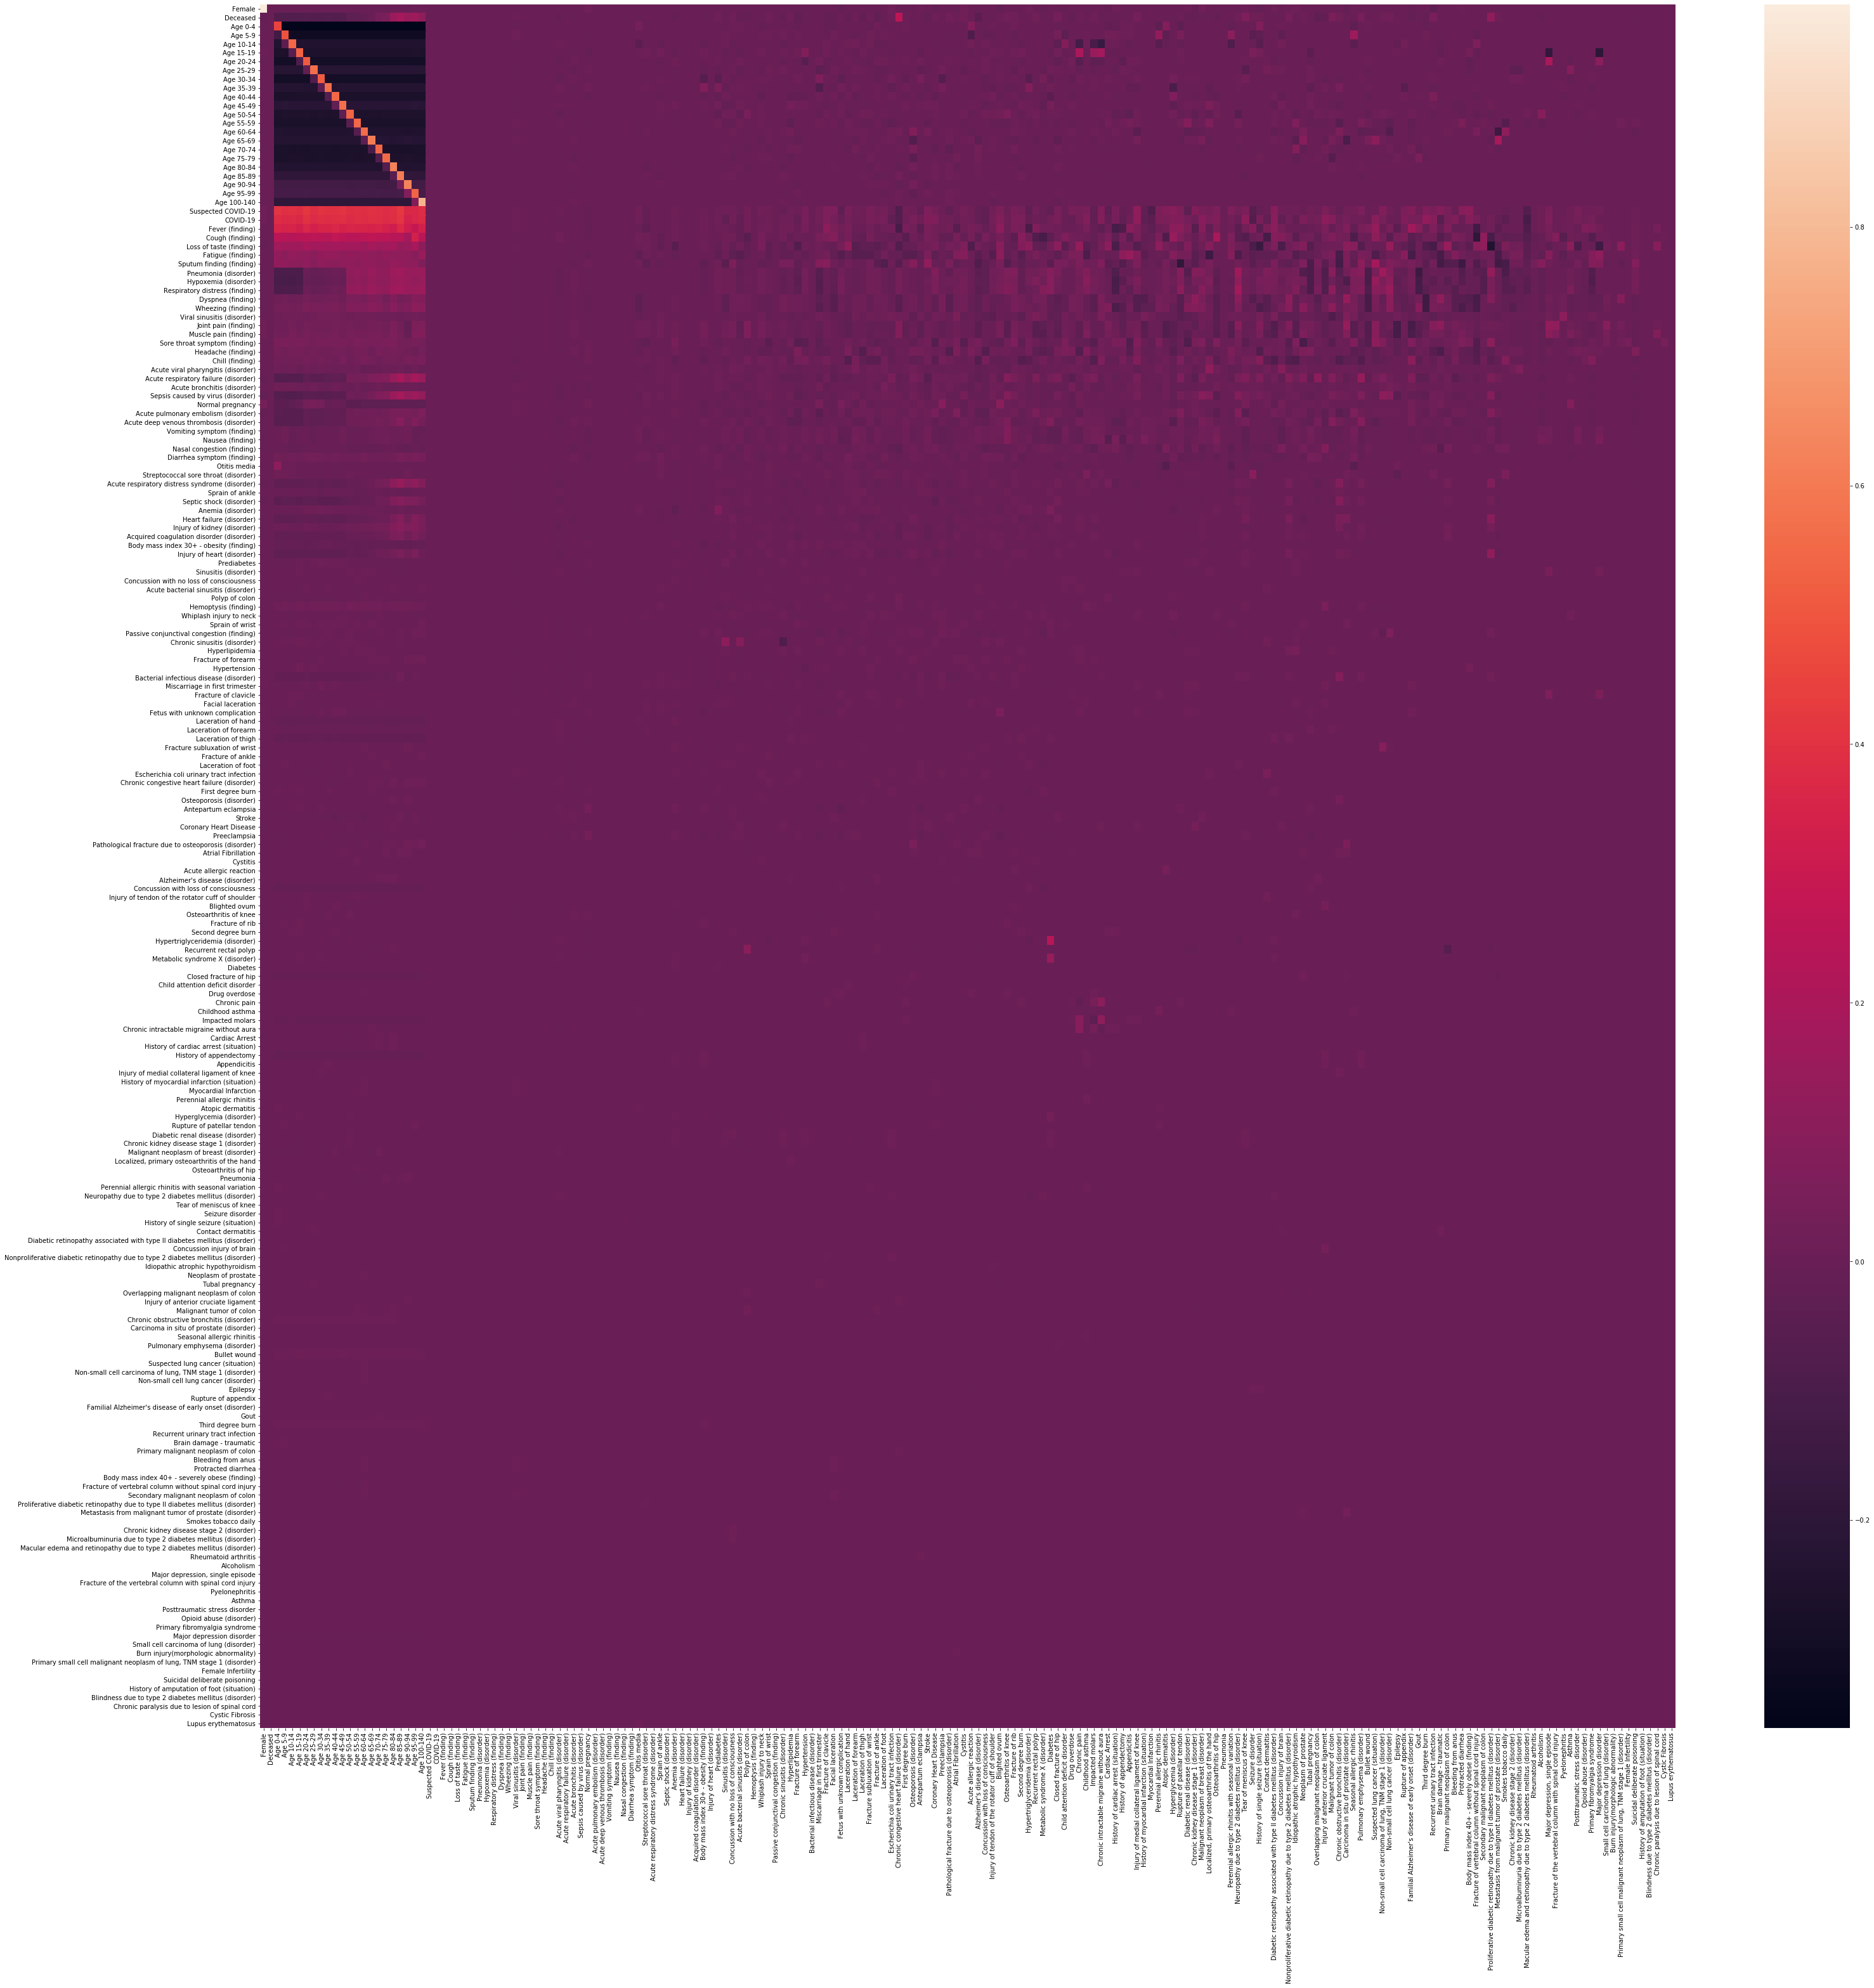

In [207]:
predictConditions.predictConditions(query)

In [64]:
import getFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
    print('Collecting all conditions:\n')
    
    conditions = getFeatures.get_conditions(
        query=query, startDate='2019-01-01', endDate='2020-12-31')
    
    print(conditions)
    


Suspected COVID-19                                      81485
COVID-19                                                78851
Fever (finding)                                         72574
Cough (finding)                                         55183
Loss of taste (finding)                                 41275
                                                        ...  
History of amputation of foot (situation)                   1
Blindness due to type 2 diabetes mellitus (disorder)        1
Chronic paralysis due to lesion of spinal cord              1
Cystic Fibrosis                                             1
Lupus erythematosus                                         1
Length: 173, dtype: int64


In [87]:
conditions = conditions[conditions>=20]

conditions


Suspected COVID-19                                81485
COVID-19                                          78851
Fever (finding)                                   72574
Cough (finding)                                   55183
Loss of taste (finding)                           41275
                                                  ...  
Brain damage - traumatic                             26
Primary malignant neoplasm of colon                  26
Bleeding from anus                                   21
Protracted diarrhea                                  21
Body mass index 40+ - severely obese (finding)       21
Length: 145, dtype: int64

In [60]:
    patients = getFeatures.get_live_patients(
        query=query, startDate='2019-12-31', endDate='2019-12-31')
    
    print('\nNumber of patients', len(patients))
    


Number of patients 92258


In [61]:
    age_groups = getFeatures.make_age_groups()
    
    print('\nAge groups\n', age_groups)
    


Age groups
 ([(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79), (80, 84), (85, 89), (90, 94), (95, 99), (100, 140)], ['Age 0-4', 'Age 5-9', 'Age 10-14', 'Age 15-19', 'Age 20-24', 'Age 25-29', 'Age 30-34', 'Age 35-39', 'Age 40-44', 'Age 45-49', 'Age 50-54', 'Age 55-59', 'Age 60-64', 'Age 65-69', 'Age 70-74', 'Age 75-79', 'Age 80-84', 'Age 85-89', 'Age 90-94', 'Age 95-99', 'Age 100-140'])


In [90]:
    print('\nCompute features: ')
    
    x_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2019-01-01', 
        endDate='2019-12-31', 
        age_groups=age_groups)

    print('\nx_df.shape ', x_df.shape)
    
    print('\nCompute labels: ')
    
    y_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2020-01-01', 
        endDate='2020-12-31', 
        age_groups=age_groups)
    
    print('\ny_df.shape ', y_df.shape)
    


Compute features: 

x_df.shape  (109321, 168)

Compute labels: 

y_df.shape  (109321, 168)


In [91]:
    train, test = train_test_split(patients, test_size=0.25, random_state=42)
    train, validate = train_test_split(train, test_size=1/3, random_state=42)
    
    x_train_df = x_df.loc[train]
    y_train_df = y_df.loc[train]
    x_validate_df = x_df.loc[validate]
    y_validate_df = y_df.loc[validate]
    x_test_df = x_df.loc[test]
    y_test_df = y_df.loc[test]
    
    print('Train set:', len(train), 'Validate set: ', len(validate), 'Test set: ', len(test))
    

Train set: 46128 Validate set:  23065 Test set:  23065


In [92]:
    print(
        '\n',
        pd.DataFrame(
            [x_train_df.mean(), y_train_df.mean()],
             index=['x_train means','y_train means']
        ).transpose()
    )


                                                 x_train means  y_train means
Female                                               0.495881       0.495881
Deceased                                             0.000000       0.033949
Age 0-4                                              0.062023       0.050685
Age 5-9                                              0.063801       0.062392
Age 10-14                                            0.063931       0.063779
...                                                       ...            ...
Brain damage - traumatic                             0.000217       0.000108
Primary malignant neoplasm of colon                  0.000217       0.000130
Bleeding from anus                                   0.000152       0.000087
Protracted diarrhea                                  0.000152       0.000087
Body mass index 40+ - severely obese (finding)       0.000108       0.000108

[168 rows x 2 columns]


In [181]:
    y_weights = 1 / (y_train_df.var() + 10e-7) / y_train_df.shape[-1]
    
    print(
        '\n',
        pd.DataFrame(
            [y_train_df.var(), y_weights],
             index=['y_train var', 'y_weights']
        ).transpose()
    )
    
    


                                                 y_train var  y_weights
Female                                             0.249988   0.023811
Deceased                                           0.032797   0.181485
Age 0-4                                            0.048117   0.123704
Age 5-9                                            0.058500   0.101748
Age 10-14                                          0.059713   0.099682
...                                                     ...        ...
Brain damage - traumatic                           0.000108  54.416975
Primary malignant neoplasm of colon                0.000130  45.417657
Bleeding from anus                                 0.000087  67.864656
Protracted diarrhea                                0.000087  67.864656
Body mass index 40+ - severely obese (finding)     0.000108  54.416975

[168 rows x 2 columns]


In [182]:
%%writefile feature_weighted_mse.py
import tensorflow as tf

def make_feature_weighted_mse(feature_weights):
    
    feature_weights = tf.reshape(tf.cast(feature_weights, 'float32'), (-1,1))
    
    def feature_weighted_mse(y_true, y_pred):
        
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        return tf.linalg.matmul(tf.square(y_true - y_pred), feature_weights)
        #tf.reduce_sum(
    
    return feature_weighted_mse

Overwriting feature_weighted_mse.py


In [183]:
import feature_weighted_mse

importlib.reload(feature_weighted_mse)

<module 'feature_weighted_mse' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/feature_weighted_mse.py'>

In [184]:
    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #1 - y means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=y_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )


Basic benchmark #1 - y means
 Train loss 0.99807465


In [185]:
    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #2 - x means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=x_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )


Basic benchmark #2 - x means
 Train loss 1.1310523


In [204]:
    print('\nTrain linear model (Lasso)\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    outputs = keras.layers.Dense(
        units=y_train_df.shape[1], 
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=wmse, optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))


Train linear model (Lasso)

Train on 46128 samples, validate on 23065 samples
Epoch 1/1000
46128/46128 [==============================] - 1s 30us/sample - loss: 3.6900 - val_loss: 1.0391
Epoch 2/1000
46128/46128 [==============================] - 1s 20us/sample - loss: 0.9704 - val_loss: 0.9592
Epoch 3/1000
46128/46128 [==============================] - 1s 15us/sample - loss: 0.9363 - val_loss: 0.9442
Epoch 4/1000
46128/46128 [==============================] - 1s 20us/sample - loss: 0.9259 - val_loss: 0.9368
Epoch 5/1000
46128/46128 [==============================] - 1s 15us/sample - loss: 0.9205 - val_loss: 0.9340
Epoch 6/1000
46128/46128 [==============================] - 1s 17us/sample - loss: 0.9183 - val_loss: 0.9301
Epoch 7/1000
46128/46128 [==============================] - 1s 20us/sample - loss: 0.9168 - val_loss: 0.9314
Epoch 8/1000
46128/46128 [==============================] - 1s 25us/sample - loss: 0.9162 - val_loss: 0.9299
Epoch 9/1000
46128/46128 [=======================

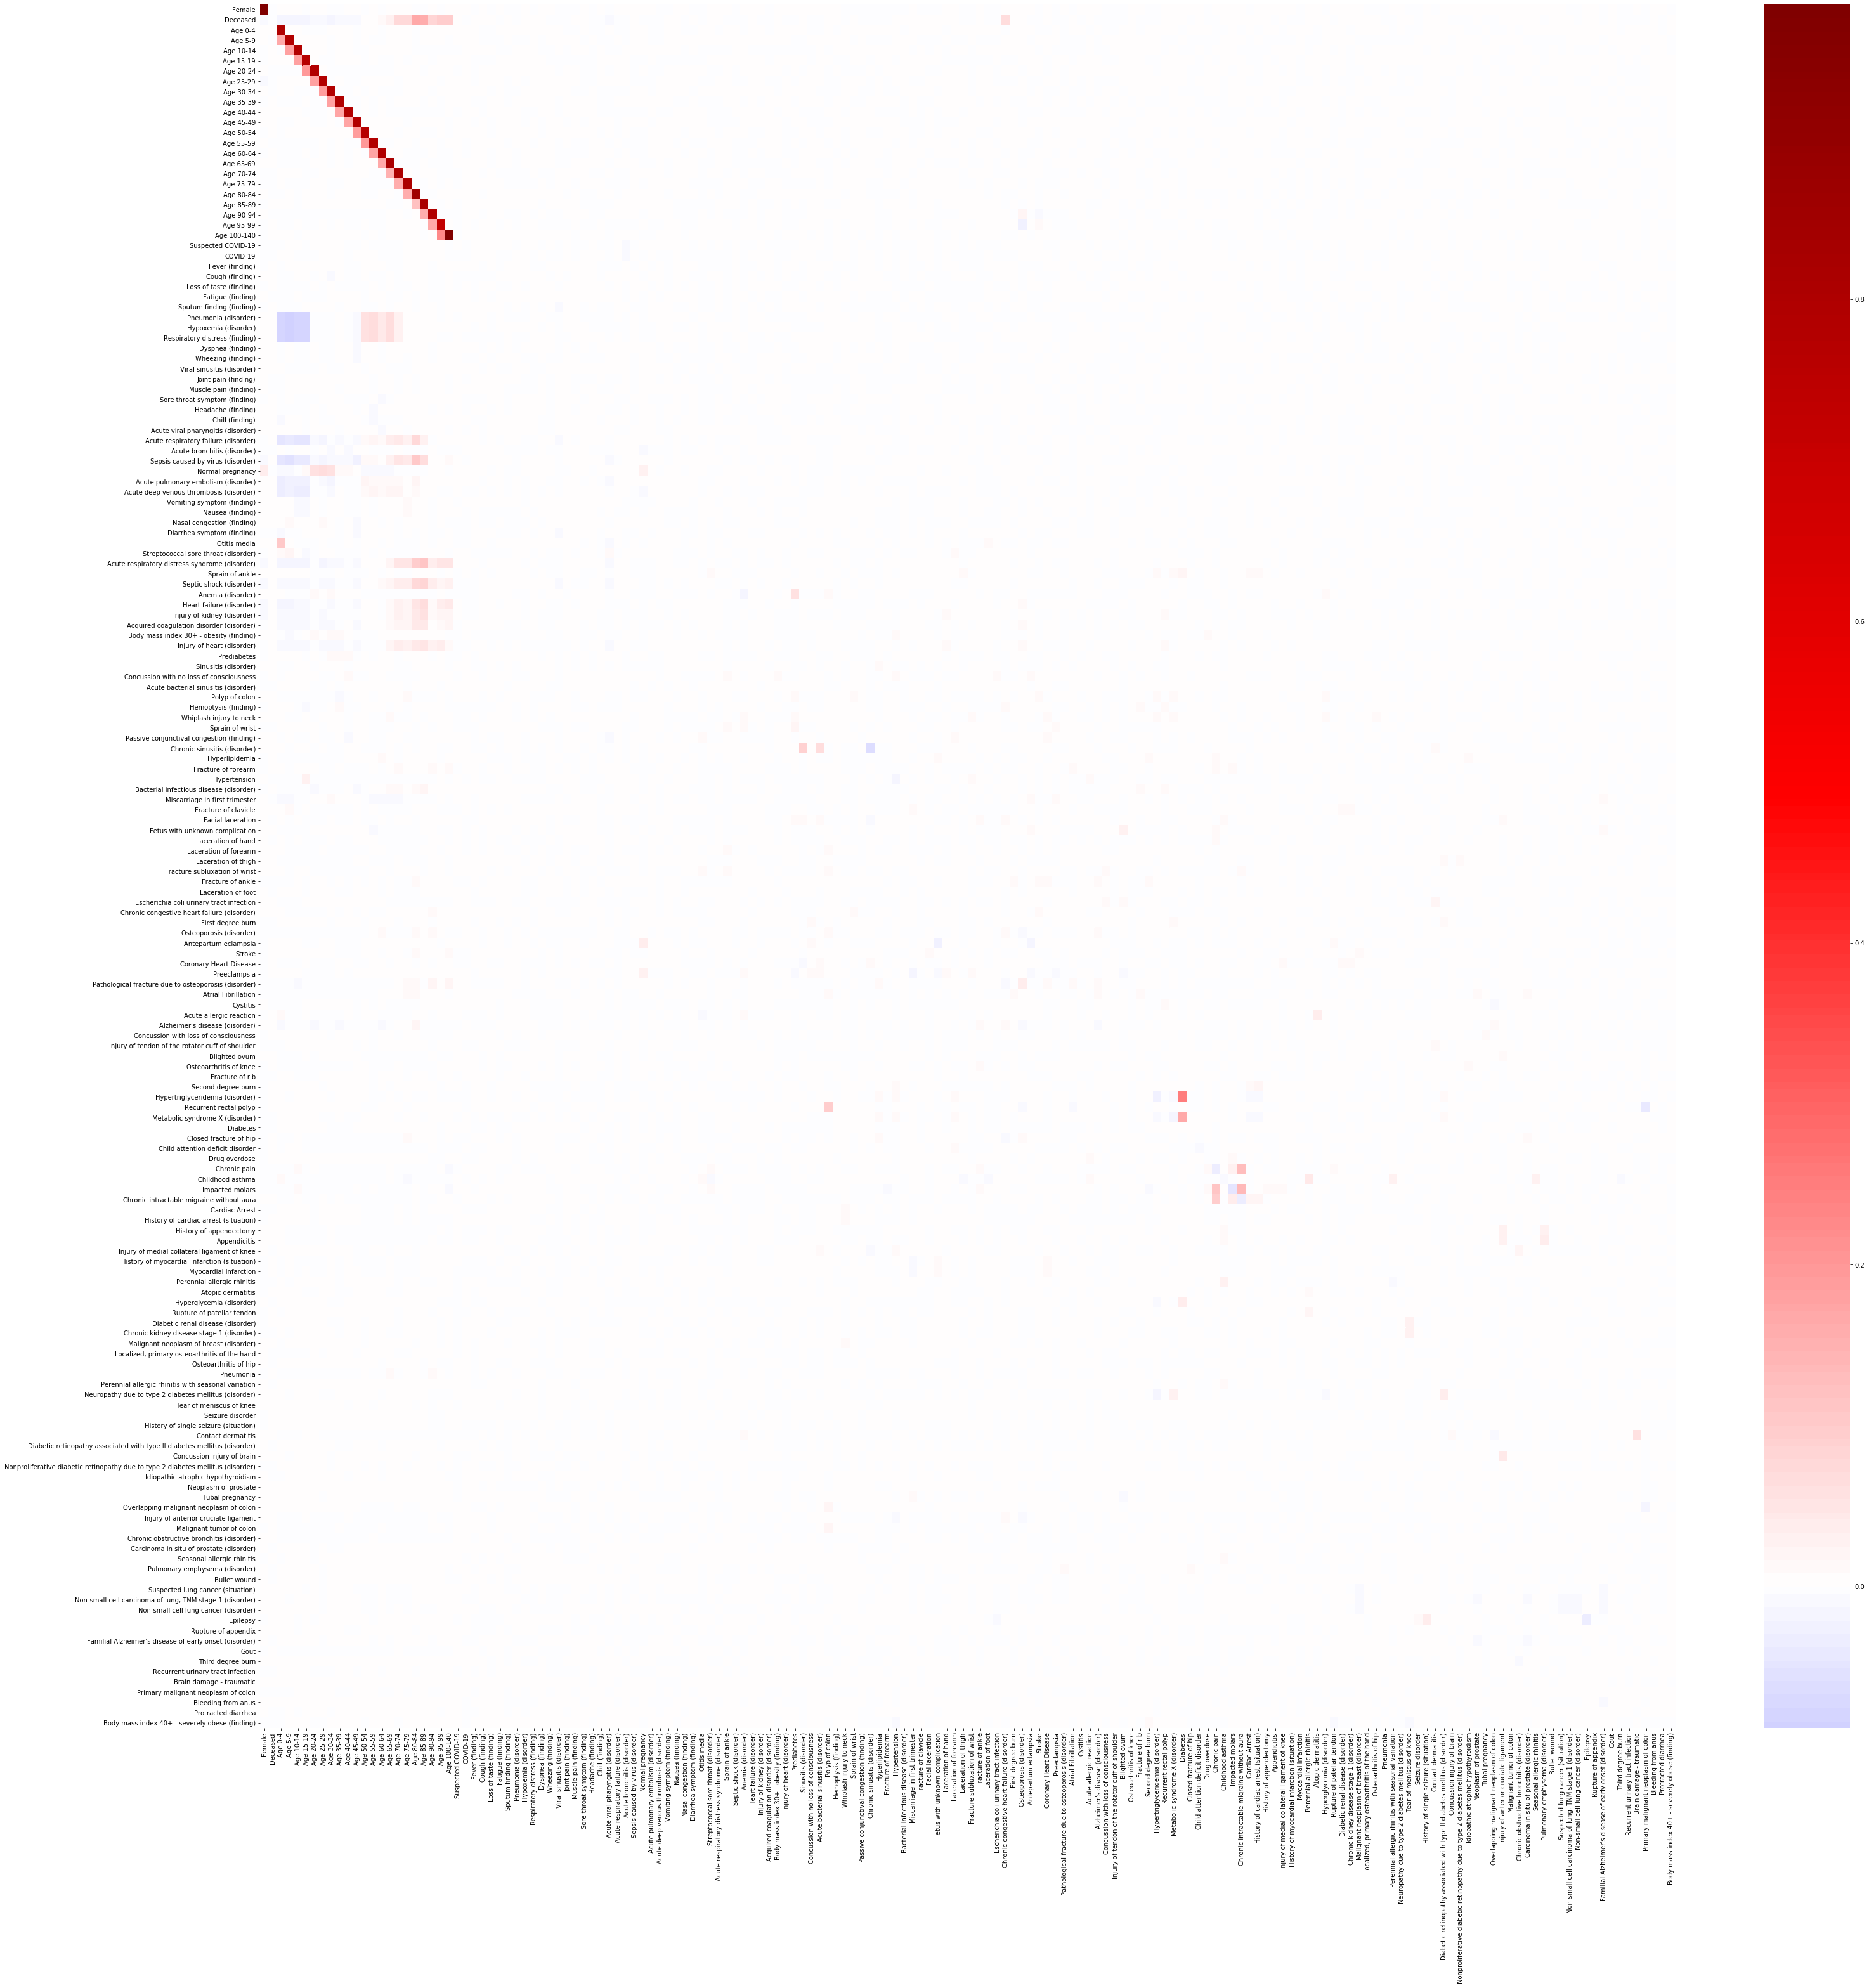

In [201]:
    f, ax = plt.subplots(figsize=(50, 50))
    ax = sns.heatmap(
        model.layers[1].get_weights()[0].transpose(), 
        xticklabels=x_train_df.columns, 
        yticklabels=x_train_df.columns,
        center=0.0,
        cmap='seismic',
    )
    
    plt.savefig('linear_coefs.png')
    

In [205]:
    print('\nTrain non-linear model (1 hidden layer):\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    x = keras.layers.Dense(
        units=128, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(inputs)
    outputs = keras.layers.Dense(
        units=y_train_df.shape[1],
        kernel_regularizer=keras.regularizers.l1(l=0.0002),
    )(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=wmse, optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))


Train non-linear model (1 hidden layer):

Train on 46128 samples, validate on 23065 samples
Epoch 1/1000
46128/46128 [==============================] - 1s 26us/sample - loss: 1.9379 - val_loss: 1.2697
Epoch 2/1000
46128/46128 [==============================] - 1s 17us/sample - loss: 1.1623 - val_loss: 1.1095
Epoch 3/1000
46128/46128 [==============================] - 1s 19us/sample - loss: 1.0547 - val_loss: 1.0369
Epoch 4/1000
46128/46128 [==============================] - 1s 21us/sample - loss: 1.0049 - val_loss: 1.0024
Epoch 5/1000
46128/46128 [==============================] - 1s 28us/sample - loss: 0.9798 - val_loss: 0.9860
Epoch 6/1000
46128/46128 [==============================] - 1s 23us/sample - loss: 0.9640 - val_loss: 0.9722
Epoch 7/1000
46128/46128 [==============================] - 1s 25us/sample - loss: 0.9523 - val_loss: 0.9589
Epoch 8/1000
46128/46128 [==============================] - 1s 19us/sample - loss: 0.9436 - val_loss: 0.9520
Epoch 9/1000
46128/46128 [=========